In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from transformers import AutoTokenizer
from transformers import BertModel  # https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertModel
from transformers import RobertaModel  # https://huggingface.co/docs/transformers/model_doc/roberta#transformers.RobertaModel
from transformers import DistilBertModel  # https://huggingface.co/docs/transformers/model_doc/distilbert#transformers.DistilBertModel


def get_model(model_name):
    assert model_name in ['bert', 'roberta', 'distilbert']
    
    checkpoint_names = {
        'bert': 'bert-base-cased',  # https://huggingface.co/bert-base-cased
        'roberta': 'roberta-base',  # https://huggingface.co/roberta-base
        'distilbert': 'distilbert-base-cased'  # https://huggingface.co/distilbert-base-cased
    }
    
    model_classes = {
        'bert': BertModel,
        'roberta': RobertaModel,
        'distilbert': DistilBertModel
    }
    
    return AutoTokenizer.from_pretrained(checkpoint_names[model_name]), model_classes[model_name].from_pretrained(checkpoint_names[model_name])

In [3]:
pip install psycopg2-binary

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 16.8 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
import pickle
from catboost import CatBoostClassifier
import pandas as pd
from sqlalchemy import create_engine

def get_model_path(path: str) -> str:
    if os.environ.get("IS_LMS") == "1":  # проверяем где выполняется код в лмс, или локально. Немного магии
        MODEL_PATH = '/workdir/user_input/model'
    else:
        MODEL_PATH = path
    return MODEL_PATH

def load_models():
    from_file = CatBoostClassifier()
    # LOAD MODEL HERE PLS :)
    loaded_model = from_file.load_model(get_model_path("catboost_model"))
    return loaded_model

def batch_load_sql(query: str) -> pd.DataFrame:
    CHUNKSIZE = 200000
    engine = create_engine(
        "postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml"
    )
    conn = engine.connect().execution_options(stream_results=True)
    chunks = []
    for chunk_dataframe in pd.read_sql(query, conn, chunksize=CHUNKSIZE):
        chunks.append(chunk_dataframe)
    conn.close()
    return pd.concat(chunks, ignore_index=True)

In [5]:
feed_data_limit = 500000
user_data_limit = 163205#114903 163205
post_text_limit = 7023#6924 7023

In [6]:
%%time
user_data = batch_load_sql(f"SELECT * FROM public.user_data LIMIT {user_data_limit}")
user_data = user_data.iloc[user_data.drop('user_id', axis=1).drop_duplicates().index.tolist()]

CPU times: user 965 ms, sys: 118 ms, total: 1.08 s
Wall time: 6.42 s


In [7]:
from category_encoders import BinaryEncoder

one_hot_columns = ['gender', 'os', 'exp_group', 'source', 'age', 'city', 'country']
dummies = pd.get_dummies(user_data[one_hot_columns].astype(object))
user_data = pd.concat([user_data['user_id'].copy(), dummies], axis = 1)

#binary_encoder = BinaryEncoder(cols=['age', 'city', 'country'])
#new_data = binary_encoder.fit_transform(user_data[['age', 'city', 'country']])
#user_data = pd.concat([user_data, new_data], axis = 1)

#user_data = user_data.drop(['gender', 'exp_group', 'os', 'source', 'country', 'city', 'age'], axis=1)
#user_data

In [8]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
pca_array = pca.fit_transform(user_data.drop('user_id', axis=1).subtract(user_data.drop('user_id', axis=1).mean()))

In [9]:
user_data.index = pd.DataFrame.from_records(pca_array).index
user_data = pd.concat([user_data['user_id'].copy(), pd.DataFrame.from_records(pca_array)], axis=1)

In [10]:
%%time
post_text = batch_load_sql(f"SELECT * FROM public.post_text_df LIMIT {post_text_limit}")
post_text = post_text.iloc[post_text.drop('post_id', axis=1).drop_duplicates().index.tolist()].dropna()

CPU times: user 56.2 ms, sys: 9.28 ms, total: 65.5 ms
Wall time: 4.94 s


In [11]:
from category_encoders import BinaryEncoder

one_hot_columns = ['topic'] 
dummies = pd.get_dummies(post_text[one_hot_columns].astype(object)) 
post_text[dummies.columns.to_list()] = dummies

In [12]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

tf = TfidfVectorizer(max_features=100000).fit_transform(post_text['text'])
svd = TruncatedSVD(n_components=10, random_state=42)
X_svd = svd.fit_transform(tf)

CPU times: user 1.45 s, sys: 49.5 ms, total: 1.5 s
Wall time: 1.46 s


from transformers import BertTokenizer
tokenizer, model = get_model('bert')
max_length = 20
embeddings = torch.empty(max_length, 1)
for index,row in post_text.iterrows():
    encoding = tokenizer.encode_plus(row['text'], add_special_tokens=True, return_token_type_ids=False, return_tensors='pt', truncation=True, max_length=max_length,padding='max_length')
    embeddings = torch.cat((embeddings, encoding['input_ids'][0].unsqueeze(1)), 1)

embedding = pd.DataFrame(StandardScaler().fit_transform(embeddings)).T.iloc[1:]
embedding.index = post_text.index
post_text = pd.concat([embedding, post_text], axis=1).drop('text', axis=1)

In [13]:
X_svd_df = pd.DataFrame(X_svd)
X_svd_df.index = post_text.index
post_text = pd.concat([X_svd_df, post_text], axis=1).drop('text',axis=1)

#test
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

X = vectorizer.fit_transform(post_text['text'])

tfidf_tokens = vectorizer.get_feature_names_out()

post_text['tf_idf'] = pd.DataFrame(
    data=X.toarray(), 
    index=[i for i in range(X.shape[0])], 
    columns=tfidf_tokens
).sum(axis=1)

from category_encoders import BinaryEncoder

one_hot_columns = ['topic']
dummies = pd.get_dummies(post_text[one_hot_columns].astype(object))
post_text[dummies.columns.to_list()] = dummies

from sklearn.preprocessing import StandardScaler

post_text = post_text.dropna().drop('topic', axis=1)

scaler = StandardScaler()
scaler.fit(post_text['tf_idf'].to_frame())
post_text['tf_idf'] = scaler.transform(post_text['tf_idf'].to_frame())

In [14]:
post_text

,0,1,2,3,4,5,6,7,8,9,post_id,topic,topic_business,topic_covid,topic_entertainment,topic_movie,topic_politics,topic_sport,topic_tech
0,0.385927,-0.175480,-0.101647,-0.085809,-0.133044,0.077495,-0.047027,0.034748,0.013438,-0.092972,1,business,1,0,0,0,0,0,0
1,0.421183,-0.200932,-0.098016,-0.001570,-0.075633,-0.013739,0.023267,0.007598,-0.022032,-0.018798,2,business,1,0,0,0,0,0,0
2,0.374554,-0.135423,-0.072829,-0.083827,-0.118489,0.048961,-0.033640,0.032693,0.024338,-0.064909,3,business,1,0,0,0,0,0,0
3,0.258534,-0.117268,-0.060226,-0.050188,-0.103498,0.029480,-0.014639,0.034757,0.014252,-0.039614,4,business,1,0,0,0,0,0,0
4,0.193898,-0.098339,-0.051587,0.001325,-0.034430,-0.000353,-0.017597,0.020375,0.009307,-0.038605,5,business,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7018,0.322424,0.197484,0.071728,0.133288,0.018117,0.119283,0.008257,0.185189,-0.011728,0.085533,7315,movie,0,0,0,1,0,0,0
7019,0.343037,0.119639,0.053088,0.075309,-0.086985,0.048079,-0.012391,0.003593,-0.023378,-0.009442,7316,movie,0,0,0,1,0,0,0
7020,0.223756,0.095997,0.034032,-0.016464,0.000560,-0.060361,-0.005122,-0.018214,0.114381,0.000028,7317,movie,0,0,0,1,0,0,0
7021,0.392392,0.115647,0.037971,0.013175,0.011984,0.013899,0.013252,-0.029763,0.127134,0.014110,7318,movie,0,0,0,1,0,0,0


In [15]:
%%time
feed_data = batch_load_sql(f"SELECT * FROM public.feed_data LIMIT {feed_data_limit}")

feed_data

CPU times: user 1.94 s, sys: 131 ms, total: 2.07 s
Wall time: 10.5 s


,timestamp,user_id,post_id,action,target
0,2021-11-18 10:46:49,130363,1571,view,0
1,2021-11-18 10:48:28,130363,3974,view,0
2,2021-11-18 10:49:30,130363,1486,view,0
3,2021-11-18 10:51:54,130363,2014,view,0
4,2021-11-18 10:52:16,130363,1094,view,0
...,...,...,...,...,...
499995,2021-11-26 08:35:05,89603,3916,like,0
499996,2021-11-26 08:35:07,89603,2696,view,0
499997,2021-11-26 08:35:24,89603,1865,view,0
499998,2021-11-26 08:35:51,89603,5854,view,0


In [16]:
df = post_text.merge(feed_data, how='inner', on='post_id').merge(user_data, how='inner', on='user_id').drop_duplicates()
#pred = feed_data.merge(user_data, how='inner', on='user_id')
#df = post_text.merge(pred, how='inner', on='post_id' )
#user_data_limit = 25000
#post_data_limit = 400

#df = post_text[:post_data_limit].merge(user_data[:user_data_limit], how='cross').merge(feed_data, how='inner', on=['user_id', 'post_id'])

In [17]:
df

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,0_y,1_y,2_y,3_y,4_y,5_y,6_y,7_y,8_y,9_y
0,0.385927,-0.175480,-0.101647,-0.085809,-0.133044,0.077495,-0.047027,0.034748,0.013438,-0.092972,...,-0.611921,0.996743,-0.252905,-0.143817,-0.228607,-0.062988,0.847475,-0.161344,0.794300,0.410164
1,0.279352,-0.131962,-0.083429,0.088089,0.061290,-0.044781,0.132314,0.041761,0.008640,-0.086380,...,-0.611921,0.996743,-0.252905,-0.143817,-0.228607,-0.062988,0.847475,-0.161344,0.794300,0.410164
2,0.391186,-0.168058,-0.096654,-0.054049,-0.155349,0.056088,-0.015916,0.063861,0.019892,-0.138366,...,-0.611921,0.996743,-0.252905,-0.143817,-0.228607,-0.062988,0.847475,-0.161344,0.794300,0.410164
3,0.068454,-0.120001,0.178399,-0.021630,-0.002696,0.017907,0.019277,0.010051,0.006394,-0.015840,...,-0.611921,0.996743,-0.252905,-0.143817,-0.228607,-0.062988,0.847475,-0.161344,0.794300,0.410164
4,0.271581,-0.086397,-0.049052,0.021821,-0.066016,-0.028997,-0.050927,0.027005,0.028262,-0.012103,...,-0.611921,0.996743,-0.252905,-0.143817,-0.228607,-0.062988,0.847475,-0.161344,0.794300,0.410164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355416,0.271027,0.061793,0.035235,0.018611,-0.004018,-0.006779,-0.022196,-0.006645,0.072039,0.018298,...,-0.559812,0.631845,1.112383,-0.147580,-0.233479,-0.059012,0.847280,-0.163939,-0.009494,-0.024392
355417,0.240424,0.048918,0.009941,-0.066327,0.043911,-0.058527,0.021107,0.025209,-0.001763,-0.061499,...,-0.559812,0.631845,1.112383,-0.147580,-0.233479,-0.059012,0.847280,-0.163939,-0.009494,-0.024392
355418,0.041901,-0.058300,0.109721,0.007618,0.001556,-0.024552,-0.012401,-0.012763,-0.004540,0.009879,...,-0.611971,0.996601,-0.252803,-0.143918,-0.228603,-0.063008,0.847317,-0.161558,0.794412,0.410116
355419,0.328250,-0.106266,-0.054937,0.099290,-0.067876,-0.073906,-0.056883,0.008643,-0.006760,0.050065,...,-0.611971,0.996601,-0.252803,-0.143918,-0.228603,-0.063008,0.847317,-0.161558,0.794412,0.410116


In [18]:
df = df.apply(lambda x:x.fillna(x.value_counts().index[0]))

In [19]:
df_copy = df.copy()
df_copy

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,0_y,1_y,2_y,3_y,4_y,5_y,6_y,7_y,8_y,9_y
0,0.385927,-0.175480,-0.101647,-0.085809,-0.133044,0.077495,-0.047027,0.034748,0.013438,-0.092972,...,-0.611921,0.996743,-0.252905,-0.143817,-0.228607,-0.062988,0.847475,-0.161344,0.794300,0.410164
1,0.279352,-0.131962,-0.083429,0.088089,0.061290,-0.044781,0.132314,0.041761,0.008640,-0.086380,...,-0.611921,0.996743,-0.252905,-0.143817,-0.228607,-0.062988,0.847475,-0.161344,0.794300,0.410164
2,0.391186,-0.168058,-0.096654,-0.054049,-0.155349,0.056088,-0.015916,0.063861,0.019892,-0.138366,...,-0.611921,0.996743,-0.252905,-0.143817,-0.228607,-0.062988,0.847475,-0.161344,0.794300,0.410164
3,0.068454,-0.120001,0.178399,-0.021630,-0.002696,0.017907,0.019277,0.010051,0.006394,-0.015840,...,-0.611921,0.996743,-0.252905,-0.143817,-0.228607,-0.062988,0.847475,-0.161344,0.794300,0.410164
4,0.271581,-0.086397,-0.049052,0.021821,-0.066016,-0.028997,-0.050927,0.027005,0.028262,-0.012103,...,-0.611921,0.996743,-0.252905,-0.143817,-0.228607,-0.062988,0.847475,-0.161344,0.794300,0.410164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355416,0.271027,0.061793,0.035235,0.018611,-0.004018,-0.006779,-0.022196,-0.006645,0.072039,0.018298,...,-0.559812,0.631845,1.112383,-0.147580,-0.233479,-0.059012,0.847280,-0.163939,-0.009494,-0.024392
355417,0.240424,0.048918,0.009941,-0.066327,0.043911,-0.058527,0.021107,0.025209,-0.001763,-0.061499,...,-0.559812,0.631845,1.112383,-0.147580,-0.233479,-0.059012,0.847280,-0.163939,-0.009494,-0.024392
355418,0.041901,-0.058300,0.109721,0.007618,0.001556,-0.024552,-0.012401,-0.012763,-0.004540,0.009879,...,-0.611971,0.996601,-0.252803,-0.143918,-0.228603,-0.063008,0.847317,-0.161558,0.794412,0.410116
355419,0.328250,-0.106266,-0.054937,0.099290,-0.067876,-0.073906,-0.056883,0.008643,-0.006760,0.050065,...,-0.611971,0.996601,-0.252803,-0.143918,-0.228603,-0.063008,0.847317,-0.161558,0.794412,0.410116


In [20]:
df_copy.drop(['timestamp', 'target', 'action', 'post_id', 'user_id'], axis=1)

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,0_y,1_y,2_y,3_y,4_y,5_y,6_y,7_y,8_y,9_y
0,0.385927,-0.175480,-0.101647,-0.085809,-0.133044,0.077495,-0.047027,0.034748,0.013438,-0.092972,...,-0.611921,0.996743,-0.252905,-0.143817,-0.228607,-0.062988,0.847475,-0.161344,0.794300,0.410164
1,0.279352,-0.131962,-0.083429,0.088089,0.061290,-0.044781,0.132314,0.041761,0.008640,-0.086380,...,-0.611921,0.996743,-0.252905,-0.143817,-0.228607,-0.062988,0.847475,-0.161344,0.794300,0.410164
2,0.391186,-0.168058,-0.096654,-0.054049,-0.155349,0.056088,-0.015916,0.063861,0.019892,-0.138366,...,-0.611921,0.996743,-0.252905,-0.143817,-0.228607,-0.062988,0.847475,-0.161344,0.794300,0.410164
3,0.068454,-0.120001,0.178399,-0.021630,-0.002696,0.017907,0.019277,0.010051,0.006394,-0.015840,...,-0.611921,0.996743,-0.252905,-0.143817,-0.228607,-0.062988,0.847475,-0.161344,0.794300,0.410164
4,0.271581,-0.086397,-0.049052,0.021821,-0.066016,-0.028997,-0.050927,0.027005,0.028262,-0.012103,...,-0.611921,0.996743,-0.252905,-0.143817,-0.228607,-0.062988,0.847475,-0.161344,0.794300,0.410164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355416,0.271027,0.061793,0.035235,0.018611,-0.004018,-0.006779,-0.022196,-0.006645,0.072039,0.018298,...,-0.559812,0.631845,1.112383,-0.147580,-0.233479,-0.059012,0.847280,-0.163939,-0.009494,-0.024392
355417,0.240424,0.048918,0.009941,-0.066327,0.043911,-0.058527,0.021107,0.025209,-0.001763,-0.061499,...,-0.559812,0.631845,1.112383,-0.147580,-0.233479,-0.059012,0.847280,-0.163939,-0.009494,-0.024392
355418,0.041901,-0.058300,0.109721,0.007618,0.001556,-0.024552,-0.012401,-0.012763,-0.004540,0.009879,...,-0.611971,0.996601,-0.252803,-0.143918,-0.228603,-0.063008,0.847317,-0.161558,0.794412,0.410116
355419,0.328250,-0.106266,-0.054937,0.099290,-0.067876,-0.073906,-0.056883,0.008643,-0.006760,0.050065,...,-0.611971,0.996601,-0.252803,-0.143918,-0.228603,-0.063008,0.847317,-0.161558,0.794412,0.410116


In [21]:
from torch.utils.data import Dataset
df_to_dataset = df_copy.drop(['timestamp', 'action', 'post_id', 'user_id', 'topic'], axis=1)
df_to_dataset

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,0_y,1_y,2_y,3_y,4_y,5_y,6_y,7_y,8_y,9_y
0,0.385927,-0.175480,-0.101647,-0.085809,-0.133044,0.077495,-0.047027,0.034748,0.013438,-0.092972,...,-0.611921,0.996743,-0.252905,-0.143817,-0.228607,-0.062988,0.847475,-0.161344,0.794300,0.410164
1,0.279352,-0.131962,-0.083429,0.088089,0.061290,-0.044781,0.132314,0.041761,0.008640,-0.086380,...,-0.611921,0.996743,-0.252905,-0.143817,-0.228607,-0.062988,0.847475,-0.161344,0.794300,0.410164
2,0.391186,-0.168058,-0.096654,-0.054049,-0.155349,0.056088,-0.015916,0.063861,0.019892,-0.138366,...,-0.611921,0.996743,-0.252905,-0.143817,-0.228607,-0.062988,0.847475,-0.161344,0.794300,0.410164
3,0.068454,-0.120001,0.178399,-0.021630,-0.002696,0.017907,0.019277,0.010051,0.006394,-0.015840,...,-0.611921,0.996743,-0.252905,-0.143817,-0.228607,-0.062988,0.847475,-0.161344,0.794300,0.410164
4,0.271581,-0.086397,-0.049052,0.021821,-0.066016,-0.028997,-0.050927,0.027005,0.028262,-0.012103,...,-0.611921,0.996743,-0.252905,-0.143817,-0.228607,-0.062988,0.847475,-0.161344,0.794300,0.410164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355416,0.271027,0.061793,0.035235,0.018611,-0.004018,-0.006779,-0.022196,-0.006645,0.072039,0.018298,...,-0.559812,0.631845,1.112383,-0.147580,-0.233479,-0.059012,0.847280,-0.163939,-0.009494,-0.024392
355417,0.240424,0.048918,0.009941,-0.066327,0.043911,-0.058527,0.021107,0.025209,-0.001763,-0.061499,...,-0.559812,0.631845,1.112383,-0.147580,-0.233479,-0.059012,0.847280,-0.163939,-0.009494,-0.024392
355418,0.041901,-0.058300,0.109721,0.007618,0.001556,-0.024552,-0.012401,-0.012763,-0.004540,0.009879,...,-0.611971,0.996601,-0.252803,-0.143918,-0.228603,-0.063008,0.847317,-0.161558,0.794412,0.410116
355419,0.328250,-0.106266,-0.054937,0.099290,-0.067876,-0.073906,-0.056883,0.008643,-0.006760,0.050065,...,-0.611971,0.996601,-0.252803,-0.143918,-0.228603,-0.063008,0.847317,-0.161558,0.794412,0.410116


In [22]:
df_to_dataset.dtypes

0_x                    float64
1_x                    float64
2_x                    float64
3_x                    float64
4_x                    float64
5_x                    float64
6_x                    float64
7_x                    float64
8_x                    float64
9_x                    float64
topic_business           uint8
topic_covid              uint8
topic_entertainment      uint8
topic_movie              uint8
topic_politics           uint8
topic_sport              uint8
topic_tech               uint8
target                   int64
0_y                    float64
1_y                    float64
2_y                    float64
3_y                    float64
4_y                    float64
5_y                    float64
6_y                    float64
7_y                    float64
8_y                    float64
9_y                    float64
dtype: object

In [23]:
class CustomDataset(Dataset):
    def __init__(self, df):
        self.labels = torch.tensor(df[['target']].to_numpy().reshape(-1)).float()
        #self.labels = torch.full((df.shape[0], 6924), 0.5)
        self.dataset = torch.tensor(df.drop('target', axis=1).values).float()

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx],self.labels[idx] 

In [24]:
dataset = CustomDataset(df_to_dataset)
dataset.__getitem__(3649)[0].shape

torch.Size([27])

In [47]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self, input_size):
        super().__init__()

        self.dropout = nn.Sequential(
            nn.Dropout(p=0.2)
        )
        n = 32
        self.block1 = nn.Sequential(
            nn.Linear(input_size, n), 
            nn.BatchNorm1d(n),
            nn.ReLU()
        )
        self.block2 = nn.Sequential(
            nn.Linear(n, n * 2), 
            nn.BatchNorm1d(n * 2),
            nn.ReLU()
        )
        self.block3 = nn.Sequential(
            nn.Linear(n * 2, 1),
            nn.Softmax(dim=0)
            #nn.Sigmoid()
            #nn.Tanh()
        )
        self.block4 = nn.Sequential(
            nn.Linear(n * 2, n * 4), 
            nn.BatchNorm1d(n * 4),
            nn.ReLU()
        )
        self.block5 = nn.Sequential(
            nn.Linear(n * 4, n * 4), 
            nn.BatchNorm1d(n * 4),
            nn.ReLU()
        )
        self.block6 = nn.Sequential(
            nn.Linear(n * 4, n * 8), 
            nn.BatchNorm1d(n * 8),
            nn.ReLU()
        )
        self.block7 = nn.Sequential(
            nn.Linear(n * 8, n * 8), 
            nn.BatchNorm1d(n * 8),
            nn.ReLU()
        )
        self.block8 = nn.Sequential(
            nn.Linear(n * 8, n * 16), 
            nn.BatchNorm1d(n * 16),
            nn.ReLU()
        )
        self.block9 = nn.Sequential(
            nn.Linear(n * 16, n * 16), 
            nn.BatchNorm1d(n * 16),
            nn.ReLU()
        )
        self.block10 = nn.Sequential(
            nn.Linear(n * 16, 1),
            #nn.Softmax(dim=0)
            #nn.Sigmoid()
            #nn.Tanh()
        )

    def forward(self, x):
        output = self.block1(x)
        output = self.block2(output)
        output = self.dropout(output)
        output = self.block3(output) + output
        #output = self.dropout(output)
        #output = self.block4(output)
        #output = self.dropout(output)
        #output = self.block5(output) + output
        #output = self.dropout(output)
        #output = self.block6(output)
        #output = self.dropout(output)
        #output = self.block7(output) + output
        #output = self.dropout(output)
        #output = self.block8(output)
        #output = self.dropout(output)
        #output = self.block9(output) + output
        #output = self.dropout(output)
        #output = self.block10(output)
        

        return output

In [48]:
#!g1.1
from tqdm import tqdm


def train(model, train_loader) -> float:
    model.train()

    train_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(train_loader, desc='Train'):
        x, y = x.to(device), y.unsqueeze(1).to(device)
        
        optimizer.zero_grad()

        output = model(x.float())
        
        #print(output, y)
        
        loss = loss_fn(output, y)
        
        train_loss += loss.item()

        loss.backward()

        total += y.size(0)
        correct += (output == y).sum().item()

    train_loss /= len(train_loader)
    accuracy = correct / total

    return train_loss, accuracy

In [49]:
#!g1.1
@torch.inference_mode()
def evaluate(model, loader):
    model.eval()

    total_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(loader, desc='Evaluation'):
        x, y = x.to(device), y.unsqueeze(1).to(device)
        
        
        output = model(x.float())
        loss = loss_fn(output, y)

        total_loss += loss.item()

        #_, y_pred = torch.max(output, 1)
        total += y.size(0)
        correct += (output == y).sum().item()

    total_loss /= len(loader)
    accuracy = correct / total

    return total_loss, accuracy

In [50]:
#!g1.1
from IPython.display import clear_output
import matplotlib.pyplot as plt

def plot_stats(
    train_loss,
    valid_loss,
    train_accuracy,
    valid_accuracy,
    title
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

    #plt.figure(figsize=(16, 8))

    #plt.title(title + ' accuracy')
    
    #plt.plot(train_accuracy, label='Train accuracy')
    #plt.plot(valid_accuracy, label='Valid accuracy')
    #plt.legend()
    #plt.grid()

    #plt.show()

In [51]:
def whole_train_valid_cycle(model, num_epochs, title, train_loader, valid_loader):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model, train_loader)
        valid_loss, valid_accuracy = evaluate(model, valid_loader)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)
        
        if epoch % 25 == 0:
            torch.save(model.state_dict(), f'net_{epoch}')
        
        clear_output()

        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
            title
        )
        scheduler.step()

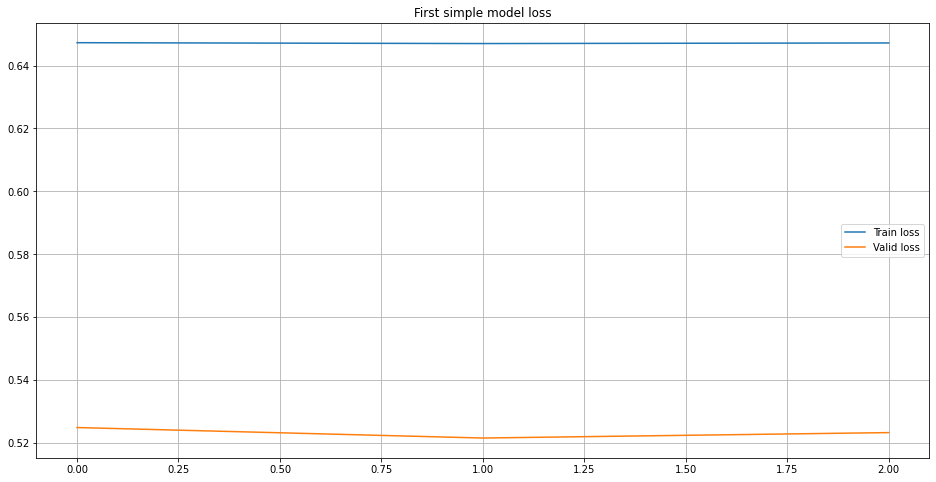

In [52]:
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CyclicLR
from torch.optim.lr_scheduler import StepLR

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=2048, shuffle=True, num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=2048, shuffle=True, num_workers=2, pin_memory=True)


net = Net(df_to_dataset.shape[1] - 1).to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)

#scheduler = CyclicLR(optimizer, base_lr=0.01, max_lr=0.1, cycle_momentum=False)
scheduler = StepLR(optimizer, step_size=50, gamma=0.1)

#loss_fn = nn.L1Loss()
loss_fn = nn.MSELoss() 
#loss_fn = nn.CrossEntropyLoss(reduction='sum')

whole_train_valid_cycle(net, 3, 'First simple model', train_loader, valid_loader)

In [31]:
torch.save(net.state_dict(), 'net')

In [32]:
df_to_dataset.shape[1] - 1

27

0_x                           float64
1_x                           float64
2_x                           float64
3_x                           float64
4_x                           float64
5_x                           float64
6_x                           float64
7_x                           float64
8_x                           float64
9_x                           float64
post_id                         int64
topic                          object
topic_business                  uint8
topic_covid                     uint8
topic_entertainment             uint8
topic_movie                     uint8
topic_politics                  uint8
topic_sport                     uint8
topic_tech                      uint8
timestamp              datetime64[ns]
user_id                         int64
action                         object
target                          int64
0_y                           float64
1_y                           float64
2_y                           float64
3_y         

In [57]:
catboost_model = CatBoostClassifier(loss_function="Logloss",
                           eval_metric="AUC",
                           task_type="GPU",
                           learning_rate=0.01,
                           iterations=70000,
                           l2_leaf_reg=50,
                           random_seed=432013,
                           od_type="Iter",
                           depth=5,
                           early_stopping_rounds=15000,
                           border_count=64,
                            metric_period= 250
                           #has_time= True 
                          )
catboost_model.fit(df_copy.drop(['timestamp', 'action', 'post_id', 'user_id', 'topic', 'target'], axis=1), df_copy['target'])

0:	total: 31ms	remaining: 36m 11s
250:	total: 9.83s	remaining: 45m 32s
500:	total: 19s	remaining: 43m 53s
750:	total: 28s	remaining: 43m
1000:	total: 38.4s	remaining: 44m 5s
1250:	total: 47.6s	remaining: 43m 38s
1500:	total: 58.2s	remaining: 44m 18s
1750:	total: 1m 8s	remaining: 44m 31s
2000:	total: 1m 18s	remaining: 44m 21s
2250:	total: 1m 27s	remaining: 44m 6s
2500:	total: 1m 37s	remaining: 43m 42s
2750:	total: 1m 45s	remaining: 42m 59s
3000:	total: 1m 54s	remaining: 42m 30s
3250:	total: 2m 2s	remaining: 42m 3s
3500:	total: 2m 12s	remaining: 41m 58s
3750:	total: 2m 21s	remaining: 41m 36s
4000:	total: 2m 29s	remaining: 40m 59s
4250:	total: 2m 37s	remaining: 40m 43s
4500:	total: 2m 48s	remaining: 40m 48s
4750:	total: 2m 57s	remaining: 40m 36s
5000:	total: 3m 6s	remaining: 40m 18s
5250:	total: 3m 16s	remaining: 40m 28s
5500:	total: 3m 24s	remaining: 39m 53s
5750:	total: 3m 34s	remaining: 39m 57s
6000:	total: 3m 43s	remaining: 39m 45s
6250:	total: 3m 53s	remaining: 39m 36s
6500:	total: 4

In [58]:
catboost_model.save_model('catboost_model', format="cbm")